## 1. train textCNN model
## 2. extract the middle layer as document Vector
## 3. transform JD&CV to Vector
## 4. use FAISS to get most simmilar Vector from Vector Matrix

In [1]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, LSTM, MaxPooling1D,BatchNormalization,GRU, SpatialDropout1D
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras import metrics, regularizers
from keras.preprocessing import sequence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from bs4 import BeautifulSoup
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

Using TensorFlow backend.


# import Job Description dataset

In [2]:
data = pd.read_csv(r'Top30.csv',usecols = ['Query','Description'])
data

,Query,Description
0,Administrative Assistant,This Administrative Assistant position is resp...
1,Administrative Assistant,ADMINISTRATIVE ASSISTANT Part Time The West Or...
2,Administrative Assistant,Administrative Assistant - In Bus 26yrs Fashi...
3,Sales Representative,Are you ready for something new? Are you tired...
4,Customer Service Representative,Superior Staff Resources is currently seeking ...
5,Customer Service Representative,<br />\r<span><strong>The Opportunity:</strong...
6,Java Developer,<P><STRONG>As a member of the Web and Portal D...
7,Java Developer,<BR>\r<TABLE border=0 cellSpacing=0 cellPaddin...
8,Administrative Assistant,The main function of this role is to provide a...
9,Financial Analyst,Financial Analyst\n Perform portfolio analysis...


In [3]:
data.Query.value_counts()

Administrative Assistant                                      4395
Customer Service Representative                               4200
Own Your Own Franchise!                                       3701
Sales Representative                                          3556
Mobile Tool Sales / Franchise Distributor                     3275
Retail Wireless Sales Consultant                              3194
Sales / Franchise                                             3120
Project Manager                                               2845
Staff Accountant                                              2834
Retail Sales Associate                                        2769
Business Analyst                                              2420
Sales / Customer Service – Part or Full time – Summer Work    2419
Sales Representative / Account Manager /  Customer Service    2412
Senior Accountant                                             2216
Jani-King Franchise Business Opportunity                      

# data clean

In [4]:
data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
#     text = BeautifulSoup(text, "lxml").text
#     pat = re.compile('<[^>]+>', re.S)
    text = text.replace(r'\\n', ' ').replace(r'\\r', ' ').replace(r'\r', ' ').replace(r'\n', ' ')
    
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    text = cleanr.sub(' ', text)
    
#     text = text.replace(r'\\n', ' ').replace(r'\\r', ' ').replace(r'\r', ' ').replace(r'\n', ' ')
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split()) # remove stopwors from text
    return text

In [5]:
data['Query'] = data['Query'].apply(clean_text)
data['Description'] = data['Description'].apply(clean_text)
data

,Query,Description
0,administrative assistant,this administrative assistant position is resp...
1,administrative assistant,administrative assistant part time the west or...
2,administrative assistant,administrative assistant in bus 26yrs fashion ...
3,sales representative,are you ready for something new are you tired ...
4,customer service representative,superior staff resources is currently seeking ...
5,customer service representative,the opportunity schweitzer engineering laborat...
6,java developer,as a member of the web and portal development ...
7,java developer,hsi the department of commerce doc is seeking ...
8,administrative assistant,the main function of this role is to provide a...
9,financial analyst,financial analyst perform portfolio analysis u...


# sample

In [6]:
data['Description'][0]

'this administrative assistant position is responsible for performing a variety of clerical and administrative support functions in the areas of communications data entry and retrieval typing filing copying and coordination of related administrative activities job requirements attention to detail ability to work in a fast paced environment invoicing proficient in word excel and outlook other administrative responsibilities as needed qualifications high school diploma administrative assistant experience 12 years work experience working knowledge of all basic office machines fax copier 10key etc strong verbal and written communication skills strong work ethic'

In [7]:
import re
from bs4 import BeautifulSoup

def string_process(l):
#     temp_list = [str(i).replace('\\n', ' ').replace('\\r', ' ').replace('\r', ' ').replace('\n', ' ').strip().lower() for i in nlp(l)]
#     temp_string = ' '.join( temp_list )
#     temp_list = [str(i) for i in nlp(temp_string)] 
    temp_list = l.split()
    return temp_list

In [8]:
data['text_clean'] = data['Description'].apply( string_process )
data['len'] = data['text_clean'].apply(len)
data = data[data['len'] < 500]
data

,Query,Description,text_clean,len
0,administrative assistant,this administrative assistant position is resp...,"[this, administrative, assistant, position, is...",90
1,administrative assistant,administrative assistant part time the west or...,"[administrative, assistant, part, time, the, w...",70
2,administrative assistant,administrative assistant in bus 26yrs fashion ...,"[administrative, assistant, in, bus, 26yrs, fa...",308
3,sales representative,are you ready for something new are you tired ...,"[are, you, ready, for, something, new, are, yo...",83
4,customer service representative,superior staff resources is currently seeking ...,"[superior, staff, resources, is, currently, se...",254
5,customer service representative,the opportunity schweitzer engineering laborat...,"[the, opportunity, schweitzer, engineering, la...",159
6,java developer,as a member of the web and portal development ...,"[as, a, member, of, the, web, and, portal, dev...",123
7,java developer,hsi the department of commerce doc is seeking ...,"[hsi, the, department, of, commerce, doc, is, ...",127
8,administrative assistant,the main function of this role is to provide a...,"[the, main, function, of, this, role, is, to, ...",204
9,financial analyst,financial analyst perform portfolio analysis u...,"[financial, analyst, perform, portfolio, analy...",39


In [9]:
import numpy as np
from gensim.models import KeyedVectors

W0424 15:33:17.832020 139956311447360 transport.py:43] unable to import 'smart_open.gcs', disabling that module


In [10]:
# load the Stanford GloVe model
filename = r'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [11]:
word2idx = {"PAD": 0,"UNK": 1} # 初始化 `[word : token]` 字典，后期 tokenize 语料库就是用该词典。
vocab_list = [(k, model.wv[k]) for k, v in model.wv.vocab.items()]

# 存储所有 word2vec 中所有向量的数组，留意其中多一位，词向量全为 0， 用于 padding
embeddings_matrix = np.zeros((len(model.wv.vocab.items()) + 2, model.vector_size))
for i in range(len(vocab_list)):
    word = vocab_list[i][0]
    word2idx[word] = i + 2
    embeddings_matrix[i + 2] = vocab_list[i][1]
    
embeddings_matrix[1] = np.mean(embeddings_matrix, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [12]:
max_seq_length = 500

In [13]:
def PreProcessInputData( text ):
    word_labels = []

    for sequence in text:
        len_text = len(sequence)

        ###########################################
        temp_word_labels = []
        for w in sequence:
            temp_word_labels.append( word2idx.get( str(w).lower(),1 ) )

        ###########################################
        temp_word_labels = temp_word_labels + [0] * ( max_seq_length - len_text )
        word_labels.append( temp_word_labels )

    return word_labels

In [14]:
def get_argmax( l ):
    return np.argmax(l)

In [15]:
XX = np.array( PreProcessInputData( data['text_clean'] ) )
YY = pd.get_dummies(data['Query']).values

In [16]:
data['category'] = list( YY )
data['category'] = data['category'].apply( get_argmax )
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Query,Description,text_clean,len,category
0,administrative assistant,this administrative assistant position is resp...,"[this, administrative, assistant, position, is...",90,2
1,administrative assistant,administrative assistant part time the west or...,"[administrative, assistant, part, time, the, w...",70,2
2,administrative assistant,administrative assistant in bus 26yrs fashion ...,"[administrative, assistant, in, bus, 26yrs, fa...",308,2
3,sales representative,are you ready for something new are you tired ...,"[are, you, ready, for, something, new, are, yo...",83,24
4,customer service representative,superior staff resources is currently seeking ...,"[superior, staff, resources, is, currently, se...",254,6
5,customer service representative,the opportunity schweitzer engineering laborat...,"[the, opportunity, schweitzer, engineering, la...",159,6
6,java developer,as a member of the web and portal development ...,"[as, a, member, of, the, web, and, portal, dev...",123,12
7,java developer,hsi the department of commerce doc is seeking ...,"[hsi, the, department, of, commerce, doc, is, ...",127,12
8,administrative assistant,the main function of this role is to provide a...,"[the, main, function, of, this, role, is, to, ...",204,2
9,financial analyst,financial analyst perform portfolio analysis u...,"[financial, analyst, perform, portfolio, analy...",39,9


In [17]:
temp_DF = data[['Query','category']].drop_duplicates()

category_dict = {}
for ind, row in temp_DF.iterrows():
    category_dict[ row['category'] ] = row['Query']

category_dict

{2: 'administrative assistant',
 24: 'sales representative',
 6: 'customer service representative',
 12: 'java developer',
 9: 'financial analyst',
 17: 'project manager',
 8: 'executive assistant',
 13: 'maintenance technician',
 16: 'physical therapist',
 28: 'store manager',
 27: 'staff accountant',
 10: 'inside sales representative',
 0: 'account executive',
 18: 'receptionist',
 26: 'senior accountant',
 4: 'business analyst',
 19: 'restaurant manager',
 1: 'account representative',
 20: 'retail sales associate',
 25: 'sales representative account manager customer service',
 23: 'sales management trainee',
 11: 'janiking franchise business opportunity',
 15: 'own your own franchise',
 5: 'cashier',
 22: 'sales franchise',
 7: 'customer service sales representative part time work',
 14: 'mobile tool sales franchise distributor',
 3: 'benefits consultant',
 21: 'sales customer service part or full time summer work'}

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split( XX,YY, test_size = 0.2, random_state = 42)
print( X_train.shape, Y_train.shape )
print( X_test.shape, Y_test.shape )

(54070, 500) (54070, 29)
(13518, 500) (13518, 29)


In [19]:
len( set( data['Query'] ) )

29

# textCNN  Embeding

In [20]:
from tensorflow import keras

feature_size = max_seq_length
dropout_rate = 0.2
num_classes  = len( set( data['Query'] ) )

inputs = keras.Input(shape=(500,), name='input_data')

embed = keras.layers.Embedding(
    len(embeddings_matrix), 
    100,
    weights=[embeddings_matrix],
    trainable=False,
#     mask_zero=True,
    input_length=XX.shape[1]
    )(inputs)
# single channel. If using real embedding, you can set one static
embed = keras.layers.Reshape((500, 100, 1), name='add_channel')(embed)

pool_outputs = []
for filter_size in [3,4,5]:
    filter_shape = (filter_size, 100)
    conv = keras.layers.Conv2D(150, filter_shape, strides=(1, 1), padding='valid',
                               data_format='channels_last', activation='relu',
                               kernel_initializer='glorot_normal',
                               bias_initializer=keras.initializers.constant(0.1),
                               name='convolution_{:d}'.format(filter_size))(embed)
    max_pool_shape = (feature_size - filter_size + 1, 1)
    pool = keras.layers.MaxPool2D(pool_size=max_pool_shape,
                                  strides=(1, 1), padding='valid',
                                  data_format='channels_last',
                                  name='max_pooling_{:d}'.format(filter_size))(conv)
    pool_outputs.append(pool)

pool_outputs = keras.layers.concatenate(pool_outputs, axis=-1, name='concatenate')
pool_outputs = keras.layers.Flatten(data_format='channels_last', name='flatten')(pool_outputs)
pool_outputs = keras.layers.Dropout(dropout_rate, name='dropout')(pool_outputs)

outputs = keras.layers.Dense(num_classes, activation='softmax',
                             kernel_initializer='glorot_normal',
                             bias_initializer=keras.initializers.constant(0.1),
                             name='dense')(pool_outputs)

model = keras.Model(inputs=inputs, outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 100)     40000200    input_data[0][0]                 
__________________________________________________________________________________________________
add_channel (Reshape)           (None, 500, 100, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
convolution_3 (Conv2D)          (None, 498, 1, 150)  45150       add_channel[0][0]                
______________________________________________________________________________________________

In [21]:
epochs = 5
batch_size = 128

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 43256 samples, validate on 10814 samples
Epoch 1/5
43256/43256 [==============================] - 37s 861us/sample - loss: 1.7673 - accuracy: 0.5794 - val_loss: 0.8651 - val_accuracy: 0.8024
Epoch 2/5
43256/43256 [==============================] - 35s 813us/sample - loss: 0.5970 - accuracy: 0.8574 - val_loss: 0.3756 - val_accuracy: 0.9111
Epoch 3/5
43256/43256 [==============================] - 35s 814us/sample - loss: 0.3329 - accuracy: 0.9112 - val_loss: 0.2622 - val_accuracy: 0.9272
Epoch 4/5
43256/43256 [==============================] - 35s 816us/sample - loss: 0.2576 - accuracy: 0.9261 - val_loss: 0.2285 - val_accuracy: 0.9318
Epoch 5/5
43256/43256 [==============================] - 35s 818us/sample - loss: 0.2235 - accuracy: 0.9335 - val_loss: 0.2123 - val_accuracy: 0.9363


In [22]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

13518/13518 [==============================] - 4s 275us/sample - loss: 0.2147 - accuracy: 0.9331
Test set
  Loss: 0.215
  Accuracy: 0.933


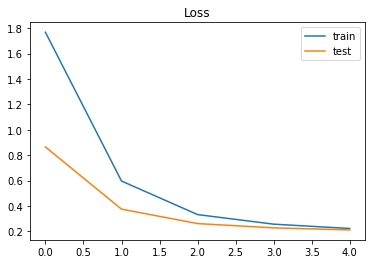

In [23]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

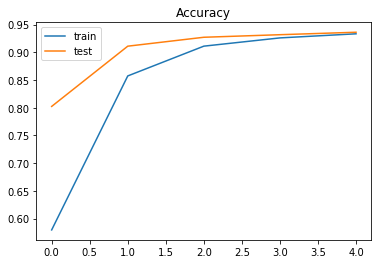

In [24]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [25]:
XX.shape

(67588, 500)

# random 500 data
# extract middle layer as document distribution presentation

In [26]:
import random
import tensorflow as tf

x_list = []
y_list = []

index = 0
while True:
    if index >= 500:
        break
    
    try:
        ranIndex = random.randint( 0,len( XX ) )

        layer_output = model.get_layer('concatenate').output
        intermediate_model = tf.keras.models.Model(inputs=model.input,outputs=layer_output)
        intermediate_prediction = intermediate_model.predict( XX[ranIndex:ranIndex+1] )

        Y_index = YY[ranIndex:ranIndex+1]

#         print( intermediate_prediction[0][0][0] )
        x_list.append( intermediate_prediction[0][0][0] )
#         y_list.append( data['Query'][ranIndex] )
        y_list.append( YY[ranIndex] )
#         print()
        index += 1

    except:
        print( 'Error' )

In [27]:
c_list = [ np.argmax(y) for y in y_list ]

# t-sne visualization

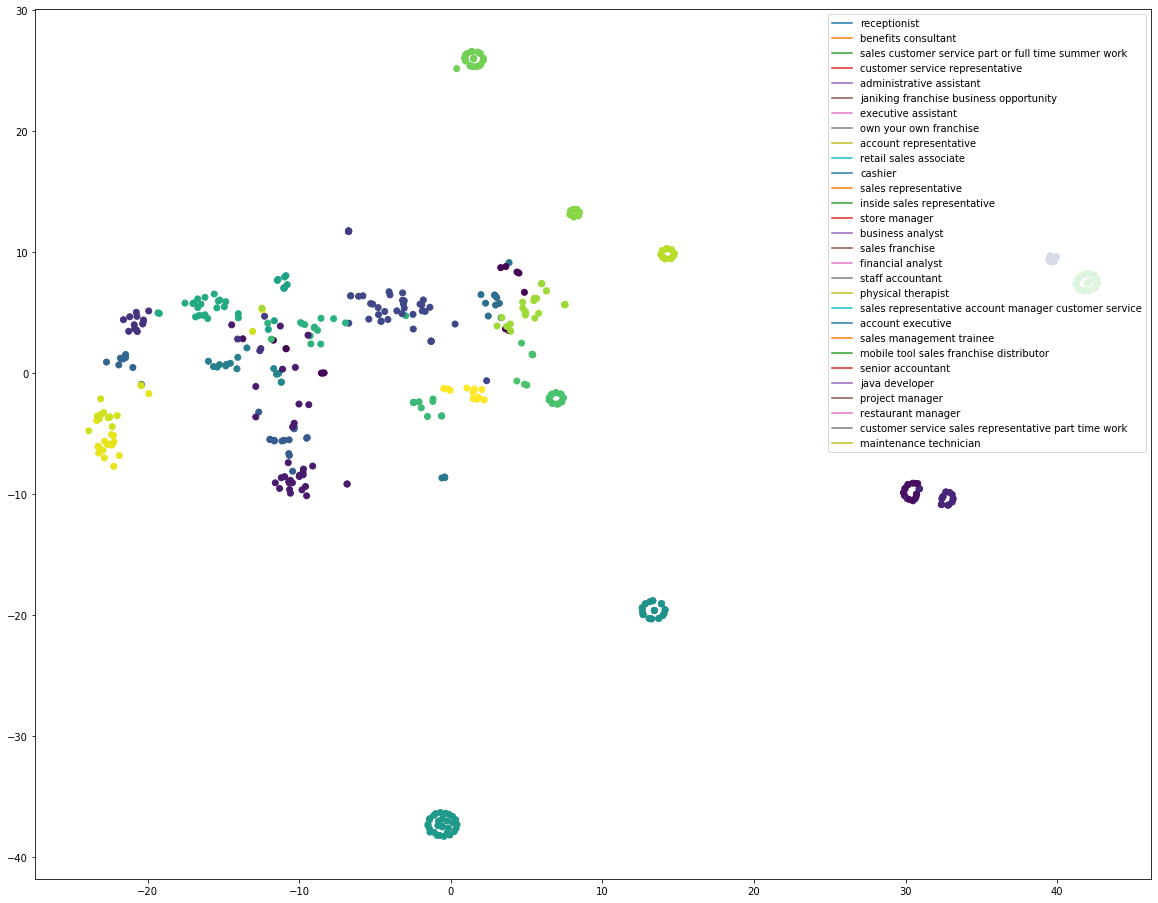

In [28]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
 
X_tsne = TSNE(learning_rate=100).fit_transform( x_list )

fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111)

ind = 0

label_list = []
for tem in X_tsne:
    if c_list[ind] not in label_list:
        ax.plot( tem[0], tem[1],label = category_dict[c_list[ind]]  )
        label_list.append( c_list[ind] )
        
    ind +=1

plt.scatter( X_tsne[:, 0], X_tsne[:, 1], c=c_list )
plt.legend()

# find the best Match 【FAISS】

In [66]:
def get_Vector_Presentation( XX ):
    layer_output = model.get_layer('concatenate').output
    intermediate_model = tf.keras.models.Model(inputs=model.input,outputs=layer_output)
    intermediate_prediction = intermediate_model.predict( XX )
    # intermediate_prediction = intermediate_model.predict( Resume_XX[0:1] )
    return intermediate_prediction

# transform CV to Vector

In [67]:
Resume_DF = pd.read_excel( 'Resumes.xlsx' ,usecols = ['title','description'])

Resume_DF['title'] = Resume_DF['title'].apply( clean_text )
Resume_DF['description'] = Resume_DF['description'].apply( clean_text )

Resume_DF['text_clean'] = Resume_DF['description'].apply( string_process )
Resume_DF['len'] = Resume_DF['text_clean'].apply(len)
Resume_DF = Resume_DF[Resume_DF['len'] < 500]

Resume_XX = np.array( PreProcessInputData( Resume_DF['text_clean'] ) )
intermediate_prediction = get_Vector_Presentation(Resume_XX)

Resume_Vector_List = []
for i in range(0,len(intermediate_prediction)):
    Resume_Vector_List.append( intermediate_prediction[i][0][0] )
    
print( Resume_XX.shape )

(65, 500)


# transform JD to Vector

In [68]:
intermediate_prediction = get_Vector_Presentation( XX )

JD_Vector_List = []
for i in range(0,len(intermediate_prediction)):
    JD_Vector_List.append( intermediate_prediction[i][0][0] )
    
np.array( JD_Vector_List ).shape

(67588, 450)

# use FAISS building Index

In [54]:
import numpy as np
import faiss                   # make faiss available

# 构造数据
import time
d = 450                           # dimension
nb = len(JD_Vector_List)                      # database size
nq = len(Resume_Vector_List)                       # nb of queries
np.random.seed(1234)             # make reproducible

xb = np.array( JD_Vector_List ).astype('float32')
xq = np.array( Resume_Vector_List ).astype('float32')

In [55]:
# 为向量集构建IndexFlatL2索引，它是最简单的索引类型，只执行强力L2距离搜索
%time index = faiss.IndexFlatL2(d)   # build the index
print(index.is_trained)
index.add(xb)                  # add vectors to the index
print(index.ntotal)

CPU times: user 139 µs, sys: 28 µs, total: 167 µs
Wall time: 153 µs
True
67588


# get a random CV

In [69]:
import random
ranIndex = random.randint( 0,len( Resume_Vector_List ) )
print( ranIndex )

k = 4
%time D, I = index.search(xq[ranIndex:ranIndex+1], k)     # actual search
print(I[0][:5])                   # neighbors of the 5 first queries

print( '-'* 120 )
print( Resume_DF['title'].iloc[ranIndex] )
print()
print( Resume_DF['description'].iloc[ranIndex] )

28
CPU times: user 154 ms, sys: 9.61 ms, total: 164 ms
Wall time: 62.8 ms
[36067 26562 67287 19657]
------------------------------------------------------------------------------------------------------------------------
web analyst

web analystweb analystsingaporework experienceweb analystdecision science agencyseptember 2018 to presentanalysed the clients website by using adobe analyticssenior process excective cognizant facebooksoftenger singaporeoctober 2017 to september 2018corresponded to inquiries and technical issues from facebook instagram advertiserseditor of free newspapermedia japan pte ltd singaporefebruary 2016 to september 2017 planned wrote translated and edited news and feature articles on politics economy sports culture and social issues in singapore and malaysia shot and edited photographs and videos managed online news site twitter instagram youtube and facebook account managed outsourced writers planned and executed promoting strategies for online news site planned

# return most simmilar JD

In [70]:
for ind in I[0][:5]:
    print(ind)
    print('-' * 120)
    print( data['Query'].iloc[ind] )
    print( data['Description'].iloc[ind] )

36067
------------------------------------------------------------------------------------------------------------------------
java developer
acts as a lead in providing application design guidance and consultation utilizing a thorough understanding of applicable technology tools and existing designs analyzes highly complex business requirements designs and writes technical specifications to design or redesign complex computer platforms and applications provides coding direction to less experienced staff or develops highly complex original code acts as an expert technical resource for modeling simulation and analysis efforts verifies program logic by overseeing the preparation of test data testing and debugging of programs oversees overall systems testing and the migration of platforms and applications to production develops new documentation departmental technical procedures and user guides leads projects allocates and manages resources and manages the work of less experienced staff a